In [32]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [33]:
import numpy as np
import pandas as pd
from scipy import stats

In [34]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [35]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [36]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [37]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [38]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [39]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [40]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [41]:
# Calculate the date 1 year ago from the last data point in the database
# First find the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date

('2017-08-23')

In [42]:
# Date 1 year ago from the last data point in the database
lastdate_strp = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
one_year_ago = dt.date(lastdate_strp.year - 1, lastdate_strp.month, lastdate_strp.day)
one_year_ago

datetime.date(2016, 8, 23)

In [43]:
# Perform a query to retrieve the date and precipitation scores
sel = [Measurement.date, Measurement.prcp]
query = session.query(*sel).filter(Measurement.date >= one_year_ago).all()

In [44]:
# Save the query results as a Pandas DataFrame and set the index to the date column
measurements_df = pd.DataFrame(query, columns=['Date', 'Precipitation'])
measurements_df = measurements_df.dropna(how='any')
measurements_df = measurements_df.set_index("Date")
measurements_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [45]:
# Sort the dataframe by date
measurements_df = measurements_df.sort_values(["Date"])
measurements_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,0.05
2016-08-23,0.70
2016-08-23,0.15
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.08


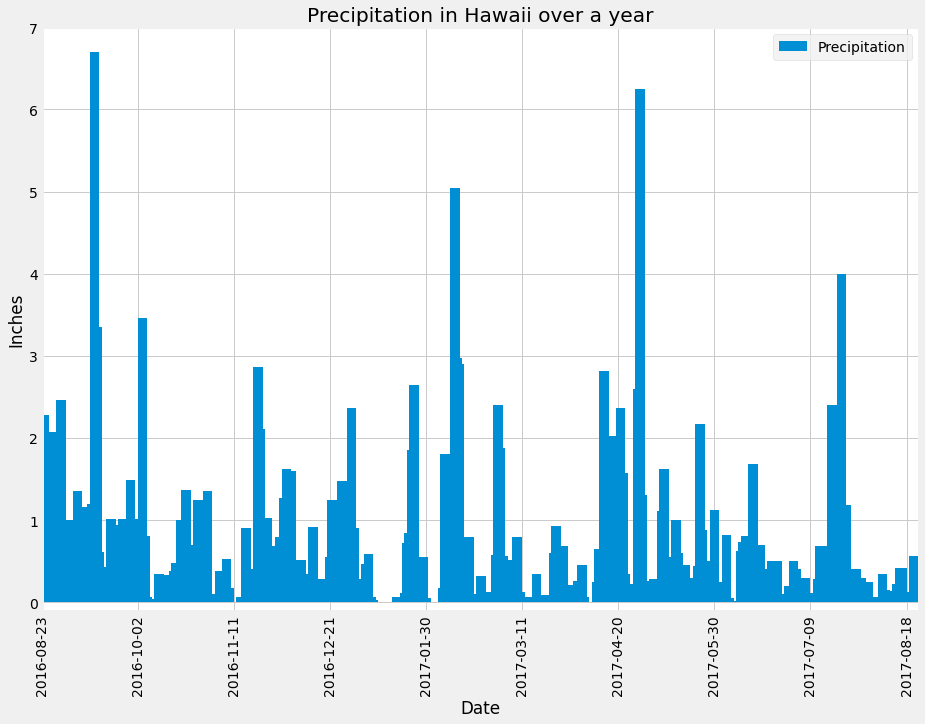

In [46]:
# Use Pandas Plotting with Matplotlib to plot the data

x = measurements_df.index.tolist()
y = measurements_df['Precipitation'].tolist()

fig, ax = plt.subplots(figsize=(14,10))
ax.bar(x,y, width=4, align="center", label='Precipitation')
major_ticks = np.arange(0,365,40)
ax.set_xticks(major_ticks)
ax.tick_params(axis='x', labelrotation=90)
ax.set_title("Precipitation in Hawaii over a year")
ax.set_xlabel("Date")
ax.set_ylabel("Inches")
ax.set_xlim("2016-08-23", "2017-08-23")
ax.set_ylim(-0.1, 7)
ax.grid(which='major', axis='both', linestyle='-')
ax.set_facecolor("white")
ax.legend()
plt.show()

In [47]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurements_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [48]:
# Design a query to show how many stations are available in this dataset?
number_stations = session.query(Station.id).count()
number_stations

9

In [49]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
count_stations =  session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
count_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
mostactivestation = session.query(*sel).\
                    filter(Measurement.station == 'USC00519281').all()
mostactivestation

[(54.0, 85.0, 71.66378066378067)]

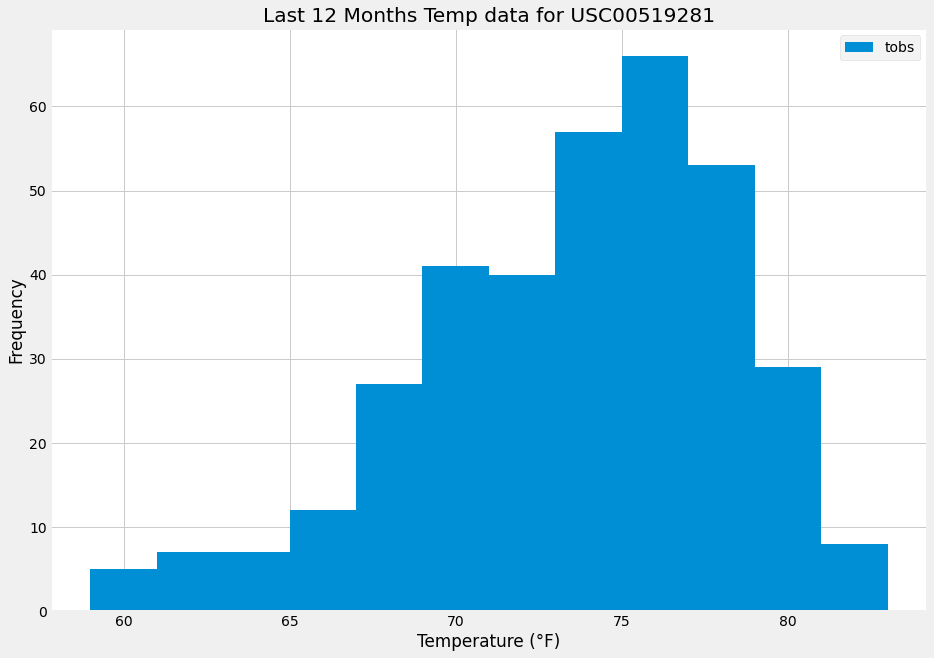

In [51]:
# Choose the station with the highest number of temperature observations - we know this from the most active station question
highest_station =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date >= one_year_ago).all()
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_df = pd.DataFrame(highest_station)
ax = highest_df.plot(kind="hist", bins=12, title="Last 12 Months Temp data for USC00519281", figsize=(14,10))
ax.set_xlabel("Temperature (°F)")
ax.set_facecolor("white")
plt.show()

## Bonus Challenge Assignment

## Temperature Analysis 1

In [52]:
# Query for each month
june = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '06').all()
december = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%m",Measurement.date) == '12').all()

# convert to DataFrames and then concatenate into one DataFrame
june = pd.DataFrame(june,columns=["Date","Temperature"])
december = pd.DataFrame(december,columns=["Date","Temperature"])
june["Month"] = "June"
december["Month"] = "December"
temp = pd.concat([june,december])

# calculate average temp for each of June and December
avg_temp_for_each_month = temp.groupby("Month").mean()
avg_temp_for_each_month

,Temperature
Month,
December,71.041529
June,74.944118


In [53]:
# t-test to determine difference in the means
stats.ttest_ind(june["Temperature"], december["Temperature"])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

Since the p-value is much less than 0.05 there is no statistical significance. I used an unpaired t-test as they are two different samples. 

## Temperature Analysis 2

In [54]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [57]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# for my trip
trip_temps = calc_temps('2016-02-28', '2016-03-05')
trip_temps

[(62.0, 69.88636363636364, 80.0)]

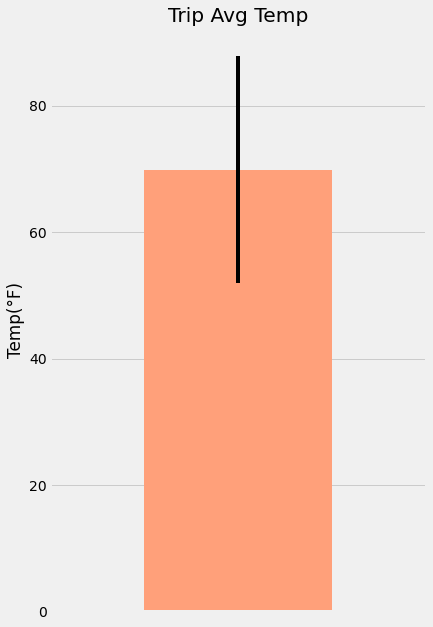

In [62]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


trip_df = pd.DataFrame(trip_temps, columns=["t_min", "t_avg", "t_max"])


plt.figure(figsize=(6,10))
ax=trip_df["t_avg"].plot.bar(yerr=(trip_df["t_max"]-trip_df["t_min"]), color="lightsalmon")
plt.title("Trip Avg Temp")
plt.ylabel("Temp(°F)")
ax.axes.get_xaxis().set_visible(False)
plt.show()

## Daily Rainfall Average

In [64]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-02-28'
end_date = '2016-03-05'

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
result = session.query(*sel).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    filter(Measurement.date >= startdate).\
    filter(Measurement.date <= enddate).\
    order_by(func.sum(Measurement.prcp).desc()).\
    all()
  
rainfall_per_stations = pd.DataFrame(result, columns=['Station','Name','Latitude','Longitude','Elevation','Precipitation Sum'])
rainfall_per_stations

,Station,Name,Latitude,Longitude,Elevation,Precipitation Sum
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.33
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.12
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.02
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.01
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
5,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.00
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


In [65]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [68]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []
# Set the start and end date of the trip
start_date = '2016-02-28'
end_date = '2016-03-05'
# Use the start and end date to create a range of dates
# Strip off the year and save a list of %m-%d strings
start_stripped = dt.datetime.strptime(start_date, '%Y-%m-%d')
end_stripped = dt.datetime.strptime(end_date, '%Y-%m-%d')

# Create this list for next part
trip_dates = []

# Loop through the list of %m-%d strings and calculate the normals for each date
while (start_stripped <= end_stripped):
    trip_dates.append(dt.datetime.strftime(start_stripped,'%Y-%m-%d'))
    datestr = dt.datetime.strftime(start_stripped,'%m-%d')
    normals.append(list(np.ravel(daily_normals(datestr))))
    start_stripped = start_stripped + dt.timedelta(days = 1)

normals

[[65.0, 70.65517241379311, 80.0],
 [67.0, 71.73333333333333, 79.0],
 [64.0, 70.0327868852459, 76.0],
 [61.0, 70.36666666666666, 78.0],
 [60.0, 70.06896551724138, 78.0],
 [57.0, 69.27272727272727, 77.0],
 [60.0, 67.89090909090909, 76.0]]

In [72]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
my_trip_df = pd.DataFrame(normals, columns=["tmin", "tavg", "tmax"])
my_trip_df["Date"] = trip_dates
my_trip_df = my_trip_df.set_index("Date")
my_trip_df

,tmin,tavg,tmax
Date,,,
2016-02-28,65.0,70.655172,80.0
2016-02-29,67.0,71.733333,79.0
2016-03-01,64.0,70.032787,76.0
2016-03-02,61.0,70.366667,78.0
2016-03-03,60.0,70.068966,78.0
2016-03-04,57.0,69.272727,77.0
2016-03-05,60.0,67.890909,76.0


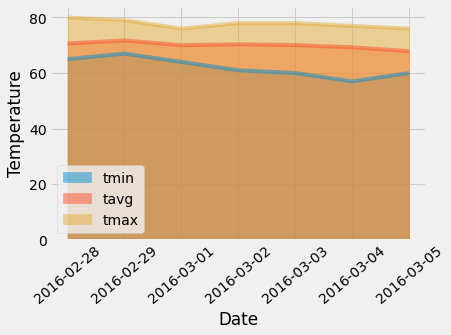

In [81]:
# Plot the daily normals as an area plot with `stacked=False`
my_trip_df.plot.area(stacked=False)
plt.ylabel("Temperature")
plt.xticks(rotation=40)
plt.show()